In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import scipy.stats as stats

### 1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

### 2. Answer those questions through a mix of statistical tests and visualizations.

### 3. Bonus: Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [2]:
# THE WRANGLE FUNCTION PERFORMS THE FOLLOWIN, IN BROAD STROKES:
# 1. Get the data via SQL query
# 2. Clean and prep the data
# 3. Encode the appropriate columns (only ['county'] for now)
# 4. Split the data: train, validate, test and X_ vs y_ splits as well
# 5. Scale the data (all train, validate and test, and all X_ and y_ splits are scaled)

df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, \
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()


In [3]:
df.shape

(61427, 29)

In [4]:
df.dtypes

parcelid                 int64
bathrooms              float64
bedrooms               float64
condition              float64
sq_ft                  float64
full_baths             float64
latitude               float64
longitude              float64
lot_size               float64
census_tract           float64
city_id                float64
zip                    float64
rooms                  float64
structure_value        float64
tax_value              float64
year_assessed          float64
land_value             float64
tax_amount             float64
logerror               float64
county                  object
age                    float64
sq_ft_per_bathroom     float64
sq_ft_per_bedroom      float64
sq_ft_per_room         float64
has_half_bath            int64
age_bin               category
Los_Angeles              uint8
Orange                   uint8
Ventura                  uint8
dtype: object

In [5]:
# for col in df.columns:
#     print(df[col].value_counts())

There may be a few duplicated parcel ids

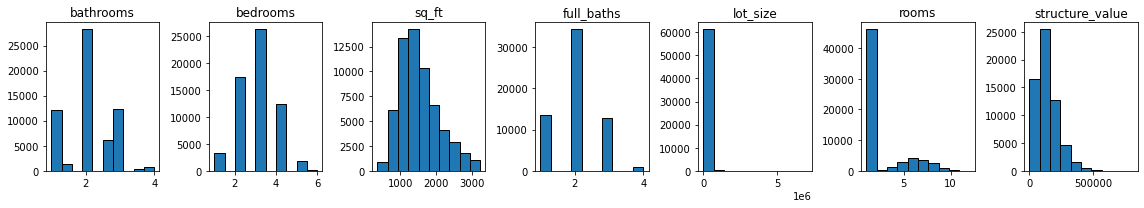

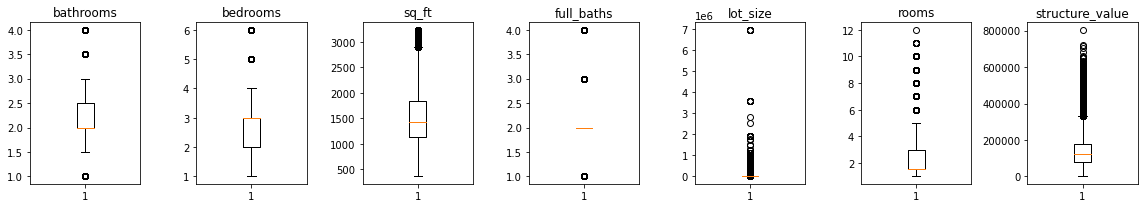

In [6]:
plt.figure(figsize=(16, 3))

# List of columns

cols = ['bathrooms', 'bedrooms', 'sq_ft', 'full_baths','lot_size','rooms', 
        'structure_value']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,7, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=10, edgecolor='black')

    # Hide gridlines.
    plt.grid(False)

    plt.tight_layout(),

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,7, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    plt.boxplot(df[col])

    # Hide gridlines.
    plt.grid(False)

    plt.tight_layout()

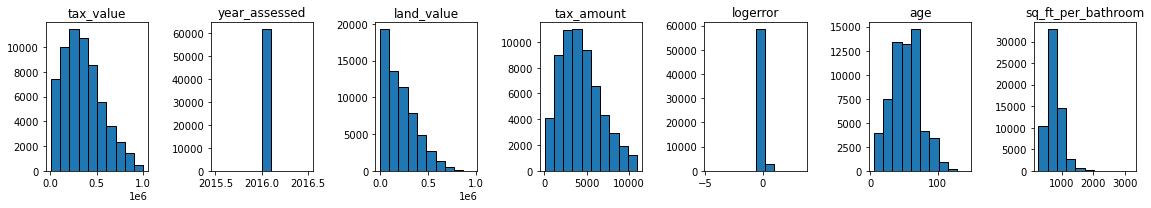

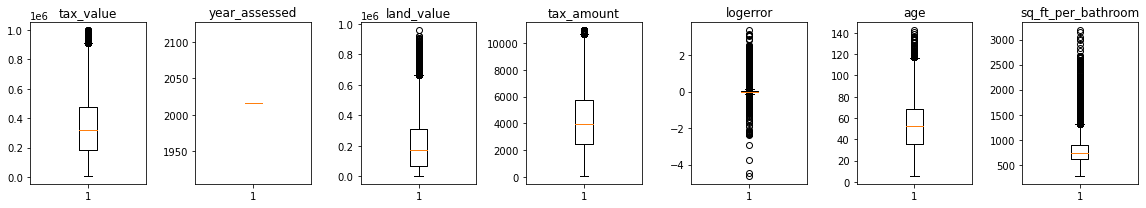

In [7]:
plt.figure(figsize=(16, 3))

# List of columns

cols = ['tax_value', 'year_assessed', 'land_value',
       'tax_amount', 'logerror', 'age', 'sq_ft_per_bathroom']
# col list from previous analysis...
# cols = ['bedrooms', 'bathrooms','sq_ft','tax_value', 'age', 'sq_ft_per_bathroom']
# Note the enumerate code, which is functioning to make a counter for use in successive plots.

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,7, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=10, edgecolor='black')

    # Hide gridlines.
    plt.grid(False)

    plt.tight_layout(),

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,7, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    plt.boxplot(df[col])

    # Hide gridlines.
    plt.grid(False)

    plt.tight_layout()

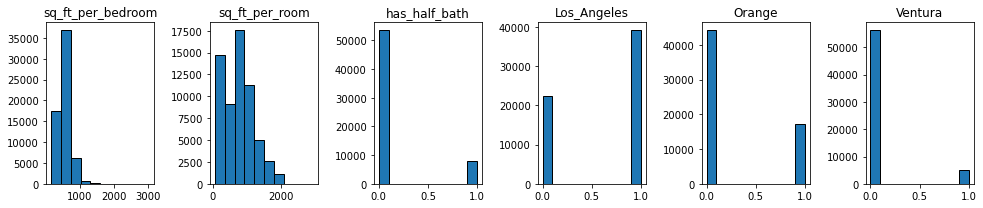

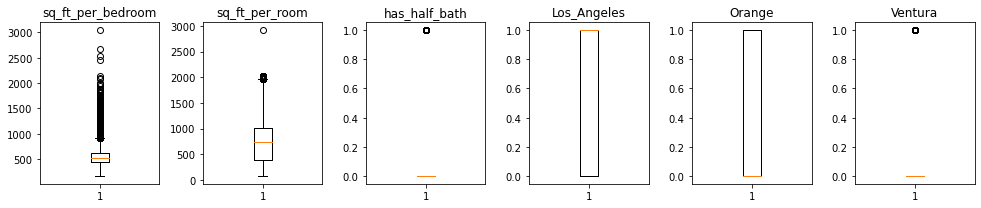

In [8]:
plt.figure(figsize=(16, 3))

# List of columns

cols = ['sq_ft_per_bedroom', 'sq_ft_per_room', 'has_half_bath',
       'Los_Angeles', 'Orange', 'Ventura']
# col list from previous analysis...
# cols = ['bedrooms', 'bathrooms','sq_ft','tax_value', 'age', 'sq_ft_per_bathroom']
# Note the enumerate code, which is functioning to make a counter for use in successive plots.

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,7, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=10, edgecolor='black')

    # Hide gridlines.
    plt.grid(False)

    plt.tight_layout(),

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,7, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    plt.boxplot(df[col])

    # Hide gridlines.
    plt.grid(False)

    plt.tight_layout()

In [9]:
df.sq_ft_per_room.value_counts()

753.482490    129
703.250324    118
678.134241    109
985.806257     98
791.156614     94
             ... 
180.833333      1
302.250000      1
366.875000      1
309.333333      1
181.285714      1
Name: sq_ft_per_room, Length: 7064, dtype: int64

<AxesSubplot:>

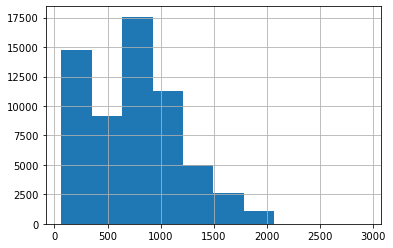

In [10]:
df.sq_ft_per_room.hist()

There aree 13 homes with 2 half baths

In [11]:
df[(df.bathrooms - df.full_baths) == 1.0]

,parcelid,bathrooms,bedrooms,condition,sq_ft,full_baths,latitude,longitude,lot_size,census_tract,...,county,age,sq_ft_per_bathroom,sq_ft_per_bedroom,sq_ft_per_room,has_half_bath,age_bin,Los_Angeles,Orange,Ventura
17426,14596237,3.0,2.0,6.0,2164.0,2.0,33546264.0,-117644144.0,7313.0,6.059032e+07,...,Orange,17.0,721.333333,1082.000000,1358.780090,1,"(0, 20]",0,1,0
18850,14495206,3.0,3.0,6.0,2096.0,2.0,33636275.0,-117598647.0,1154.0,6.059032e+07,...,Orange,8.0,698.666667,698.666667,1316.082749,1,"(0, 20]",0,1,0
22554,13886316,3.0,4.0,6.0,2542.0,2.0,33745931.0,-118092449.0,5500.0,6.059100e+07,...,Orange,56.0,847.333333,635.500000,363.142857,1,"(40, 60]",0,1,0
24148,14270757,3.0,2.0,6.0,1736.0,2.0,33643479.0,-117905409.0,1541.0,6.059063e+07,...,Orange,7.0,578.666667,868.000000,1090.038002,1,"(0, 20]",0,1,0
35554,14751722,3.0,2.0,6.0,2338.0,2.0,33509325.0,-117732456.0,7313.0,6.059042e+07,...,Orange,32.0,779.333333,1169.000000,1468.035051,1,"(20, 40]",0,1,0
36395,14596241,3.0,2.0,6.0,2164.0,2.0,33546264.0,-117644144.0,7313.0,6.059032e+07,...,Orange,17.0,721.333333,1082.000000,1358.780090,1,"(0, 20]",0,1,0
40847,14667930,3.0,2.0,6.0,1766.0,2.0,33610539.0,-117891314.0,7313.0,6.059063e+07,...,Orange,46.0,588.666667,883.000000,353.200000,1,"(40, 60]",0,1,0
45049,14495238,3.0,3.0,6.0,2096.0,2.0,33635478.0,-117597518.0,1154.0,6.059032e+07,...,Orange,8.0,698.666667,698.666667,1316.082749,1,"(0, 20]",0,1,0
51602,14722083,3.0,3.0,6.0,2857.0,2.0,33578836.0,-117727356.0,7313.0,6.059063e+07,...,Orange,14.0,952.333333,952.333333,1793.916228,1,"(0, 20]",0,1,0
52031,14495233,3.0,3.0,6.0,2096.0,2.0,33635667.0,-117598148.0,1256.0,6.059032e+07,...,Orange,8.0,698.666667,698.666667,1316.082749,1,"(0, 20]",0,1,0


## Is there a time period that has a higher or lower log error?
Bin the age group--ten bins? And see results.  Hue on county...if that makes a difference

<AxesSubplot:xlabel='age', ylabel='logerror'>

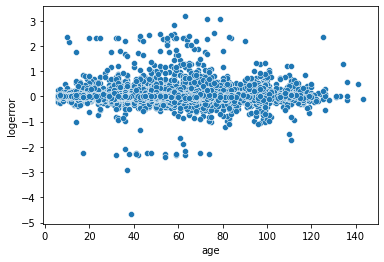

In [12]:
sns.scatterplot(x='age', y='logerror', data=train)

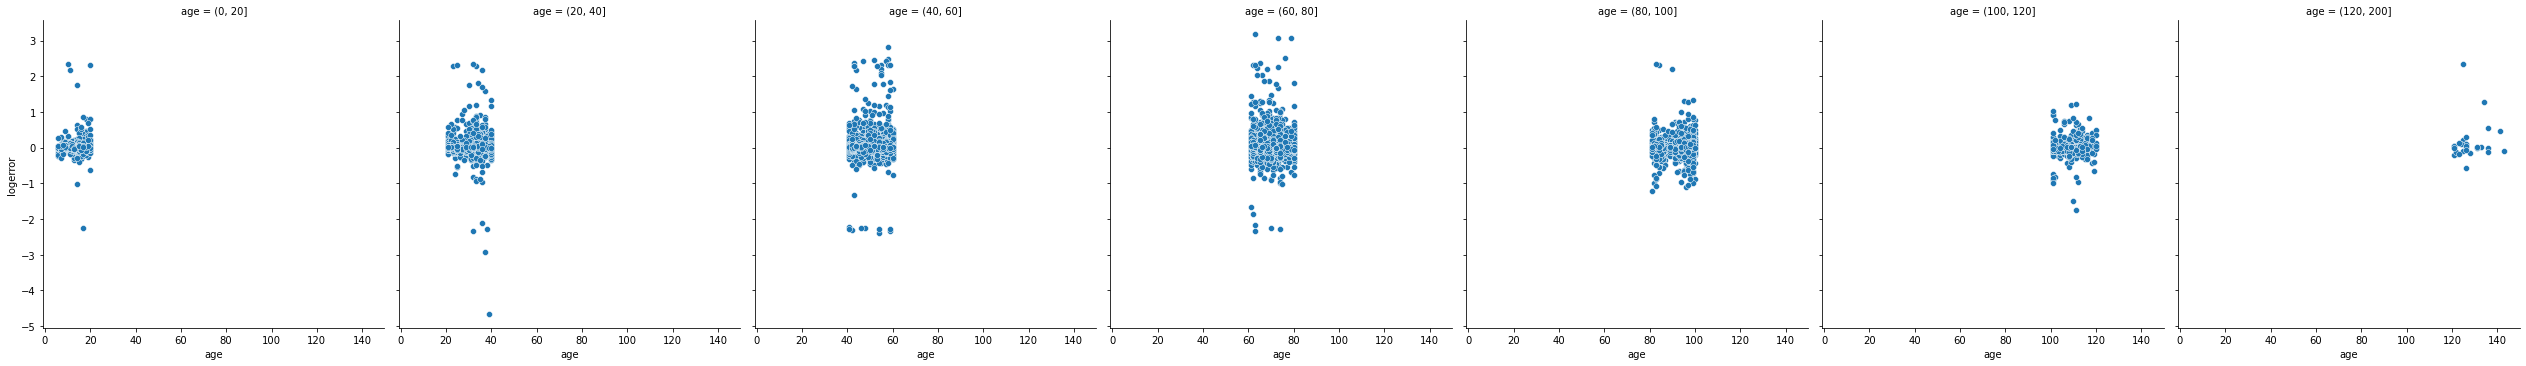

In [13]:
sns.relplot(
    data=train,
    y='logerror',
    x='age',
    col=pd.cut(df.age, bins=[0, 40,80,120,200]),
)

Things look a little tighter on either end...the 40-60 and the 60-80 look like they have a wider distribution of logerror

<AxesSubplot:xlabel='age_bin', ylabel='logerror'>

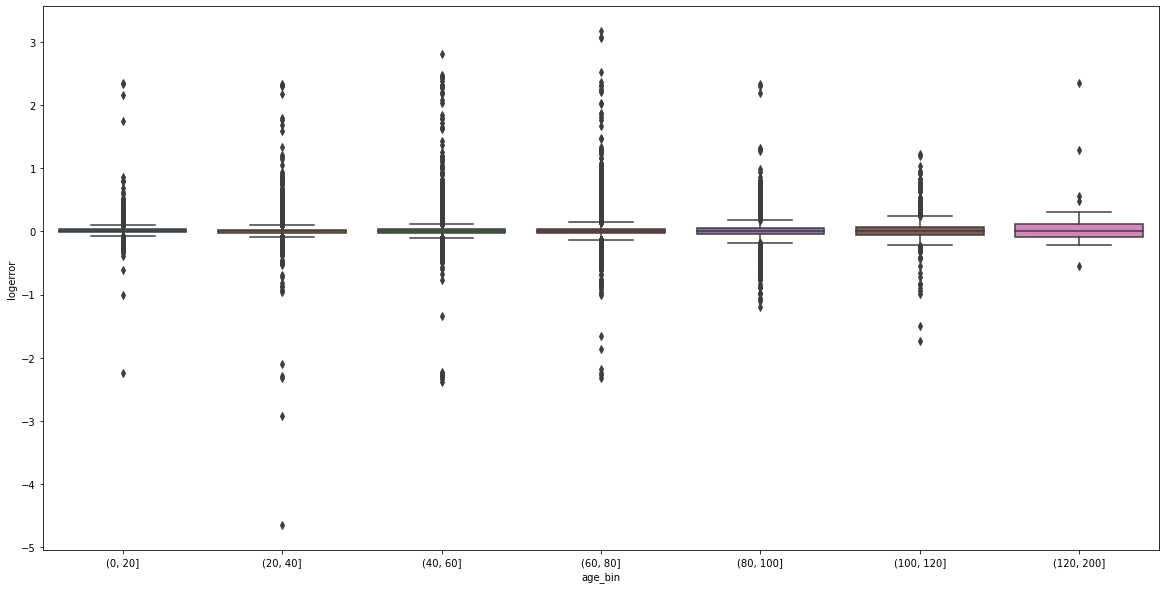

In [14]:
plt.figure(figsize=(20,10))
sns.boxplot(x='age_bin', y='logerror', data= train)

Still looks like there are more outliers in the middle, but this could be due to more data being available in those age bins

<AxesSubplot:xlabel='logerror', ylabel='Count'>

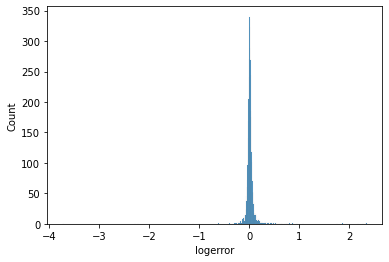

In [15]:
sns.histplot(data=train, x= df[df.age_bin == pd.Interval(0, 20)].logerror)

Text(0.5, 1.0, '120 and Up')

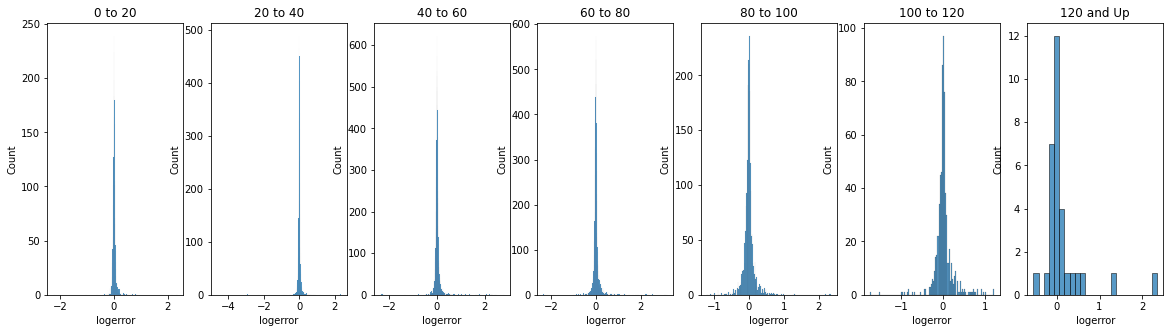

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1,7,1)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(0, 20)].logerror)
plt.title("0 to 20")
plt.subplot(1,7,2)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(20, 40)].logerror)
plt.title("20 to 40")
plt.subplot(1,7,3)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(40, 60)].logerror)
plt.title("40 to 60")
plt.subplot(1,7,4)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(60, 80)].logerror)
plt.title("60 to 80")
plt.subplot(1,7,5)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(80, 100)].logerror)
plt.title("80 to 100")
plt.subplot(1,7,6)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(100, 120)].logerror)
plt.title("100 to 120")
plt.subplot(1,7,7)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(120, 200)].logerror)
plt.title("120 and Up")

Looking at logerror by age_bin, they are generally normally distributed

Maybe run an ANOVA test to see about the variances? 

First, Levene

In [17]:
#H0: Variances are equal
#Ha: Variances are not equal

stats.levene(
    train[train.age_bin == pd.Interval(0, 20)].logerror,
    train[train.age_bin == pd.Interval(20,40)].logerror,
    train[train.age_bin == pd.Interval(40,60)].logerror,
    train[train.age_bin == pd.Interval(60,80)].logerror,
    train[train.age_bin == pd.Interval(80,100)].logerror,
    train[train.age_bin == pd.Interval(100,120)].logerror,
    train[train.age_bin == pd.Interval(120,200)].logerror
)

LeveneResult(statistic=80.46657307766738, pvalue=2.2208384391778713e-100)

The results show that the null hypothesis is rejected

In [18]:
train[train.age_bin == pd.Interval(0, 20)].logerror.var()

0.014785431537408711

In [19]:
train[train.age_bin == pd.Interval(120,200)].logerror.var()

0.262808154282573

#### Anova testing of the logerror by age_bin

Set Hypothesis
- 𝐻0 : Population means of logerror (by age_bin) are equal
- 𝐻𝑎 : Population means of logerror (by age_bin) are not all equal

In [20]:
# This cell runs an ANOVA test on the different 'age_bins'
# We are demonstrating statistically that the age correlates to the logerror
f, p = stats.f_oneway(
    train[train.age_bin == pd.Interval(0, 20)].logerror,
    train[train.age_bin == pd.Interval(20,40)].logerror,
    train[train.age_bin == pd.Interval(40,60)].logerror,
    train[train.age_bin == pd.Interval(60,80)].logerror,
    train[train.age_bin == pd.Interval(80,100)].logerror,
    train[train.age_bin == pd.Interval(100,120)].logerror,
    train[train.age_bin == pd.Interval(120,200)].logerror
)
f, p

(7.556767498292093, 4.054882771843663e-08)

In [21]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


#### The anova test shows I can proceed with the understanding that the average logerror is different depending on the age of the home

In [22]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'condition', 'sq_ft', 'full_baths',
       'latitude', 'longitude', 'lot_size', 'census_tract', 'city_id', 'zip',
       'rooms', 'structure_value', 'tax_value', 'year_assessed', 'land_value',
       'tax_amount', 'logerror', 'county', 'age', 'sq_ft_per_bathroom',
       'sq_ft_per_bedroom', 'sq_ft_per_room', 'has_half_bath', 'age_bin',
       'Los_Angeles', 'Orange', 'Ventura'],
      dtype='object')

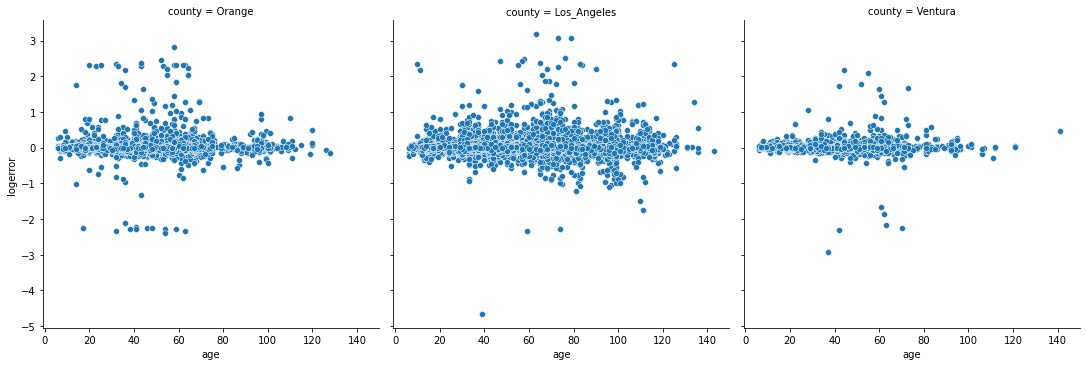

In [23]:
sns.relplot(data=train, y='logerror', x='age', col='county')

This relplot shows age and logerror by county; any dignificant differences between the counties aren't clear

### What about a relationship between tax_value and logerror? (also: are these related targets?)

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

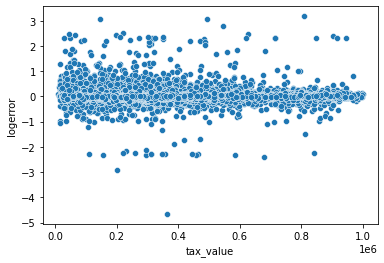

In [24]:
sns.scatterplot(x=train.tax_value, y=train.logerror, data=train)

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

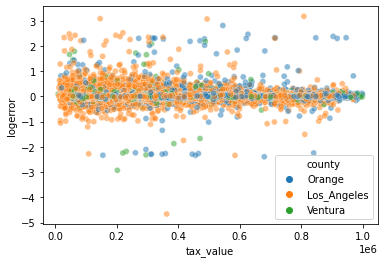

In [25]:
sns.scatterplot(x=train.tax_value, y=train.logerror, data=train, hue='county', alpha=.5)

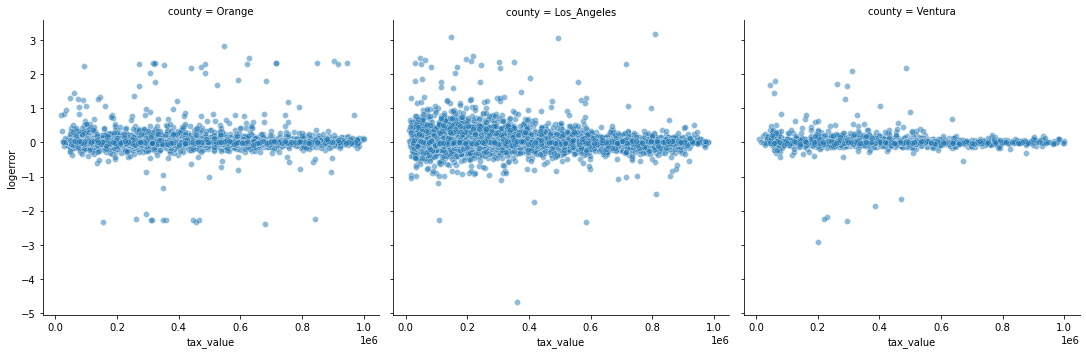

In [26]:
sns.relplot(x=train.tax_value, y=train.logerror, data=train, col='county', alpha=.5)

In [28]:
train[train.county=='Los_Angeles'].shape

(21937, 29)

In [29]:
train[train.county=='Orange'].shape

(9615, 29)

In [30]:
train[train.county=='Ventura'].shape

(2846, 29)

### No clear impressions

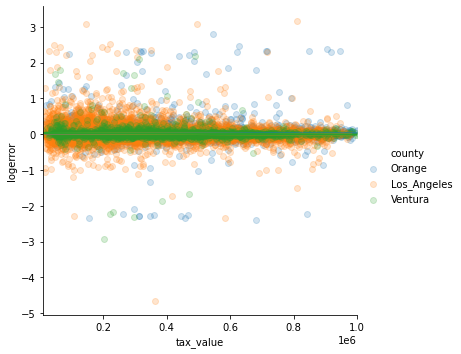

In [31]:
sns.lmplot(x='tax_value', y='logerror', data=train, scatter_kws={'alpha':.2},hue='county')

### Look like perfectly flat trend lines

In [32]:
train.head().T

,48567,1850,40927,37635,33422
parcelid,14147859,12762782,10989920,10759529,17221628
bathrooms,2.0,2.0,2.0,1.0,3.0
bedrooms,5.0,3.0,2.0,2.0,4.0
condition,6.0,6.0,8.0,6.0,6.0
sq_ft,2705.0,1259.0,1037.0,1000.0,2257.0
full_baths,2.0,2.0,2.0,1.0,3.0
latitude,33906312.0,33890056.0,34238000.0,34140540.0,34265763.0
longitude,-117922722.0,-118005231.0,-118366000.0,-118628084.0,-118799137.0
lot_size,11590.0,6770.0,208988.0,5357.0,8003.0
census_tract,60590016.013008,60375039.012005,60371021.071007,60378001.011005,61110075.14301
